In [2]:
import os
os.environ["KERAS_BACKEND"]="tensorflow"
import tensorflow as tf
import keras_cv
import keras
print("Tensorflow ",tf.__version__)
print("keras ", keras.__version__)
print("Nombre de GPUs disponibles :", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

Tensorflow  2.15.0
keras  2.15.0
Nombre de GPUs disponibles : 1
True


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras_cv.layers import Resizing
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import random
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.initializers import RandomNormal
from livelossplot import PlotLossesKeras
import time

In [19]:
# Charger les données à partir des répertoires redimensionnés

train_data, val_test = tf.keras.preprocessing.image_dataset_from_directory(
    "Resized_Images",
    labels="inferred",
    label_mode="int",
    image_size=(224, 224),
    batch_size=32,
    shuffle=True,
    seed=0,
    validation_split=0.25,  # la proportion de données à utiliser pour la validation + test
    subset="both",
)

Found 20580 files belonging to 120 classes.
Using 15435 files for training.
Using 5145 files for validation.


In [20]:
# Mélanger l'ensemble validation + test
val_test_shuffled = val_test.shuffle(buffer_size=len(val_test))

# Définir la taille des ensembles de validation et de test
val_size = int(0.6 * len(val_test_shuffled))

# Séparer les ensembles de validation et de test
val_data = val_test_shuffled.take(val_size)
test_data = val_test_shuffled.skip(val_size)

## 1. Modèle EfficientNetB0

In [15]:
from tensorflow.keras.layers import Rescaling, BatchNormalization
from tensorflow.keras.layers import Activation, SeparableConv2D, GlobalAveragePooling2D, add

In [16]:
from tensorflow.keras.applications import EfficientNetB0

In [24]:
def make_model(input_shape, num_classes):
    # inputs = keras.Input(shape=(image_size, image_size, 3))
    inputs = keras.Input(shape=input_shape)
    
    # Charger le modèle pré-entraîné
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Geler les poids pré-entraînés
    model.trainable = False

    # Reconstruire la partie supérieure du modèle
    x = GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = BatchNormalization()(x)

    top_dropout_rate = 0.3
    x = Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = Dense(num_classes, activation="softmax", name="pred")(x)

    # Compiler le modèle
    model = keras.Model(inputs, outputs, name="EfficientNet")
    
    optimizer = keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model


In [25]:
image_size=(224,224)
num_classes=120

with tf.device('/GPU:0'):
    model = make_model(input_shape=image_size + (3,), num_classes=num_classes)
    
plotloss = PlotLossesKeras()
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, mode='max'),
model_checkpoint = ModelCheckpoint(filepath='Models/EfficientNet.h5', monitor='val_accuracy',verbose=1, save_best_only=True, mode='max')
callbacks = [plotloss, early_stopping, model_checkpoint]

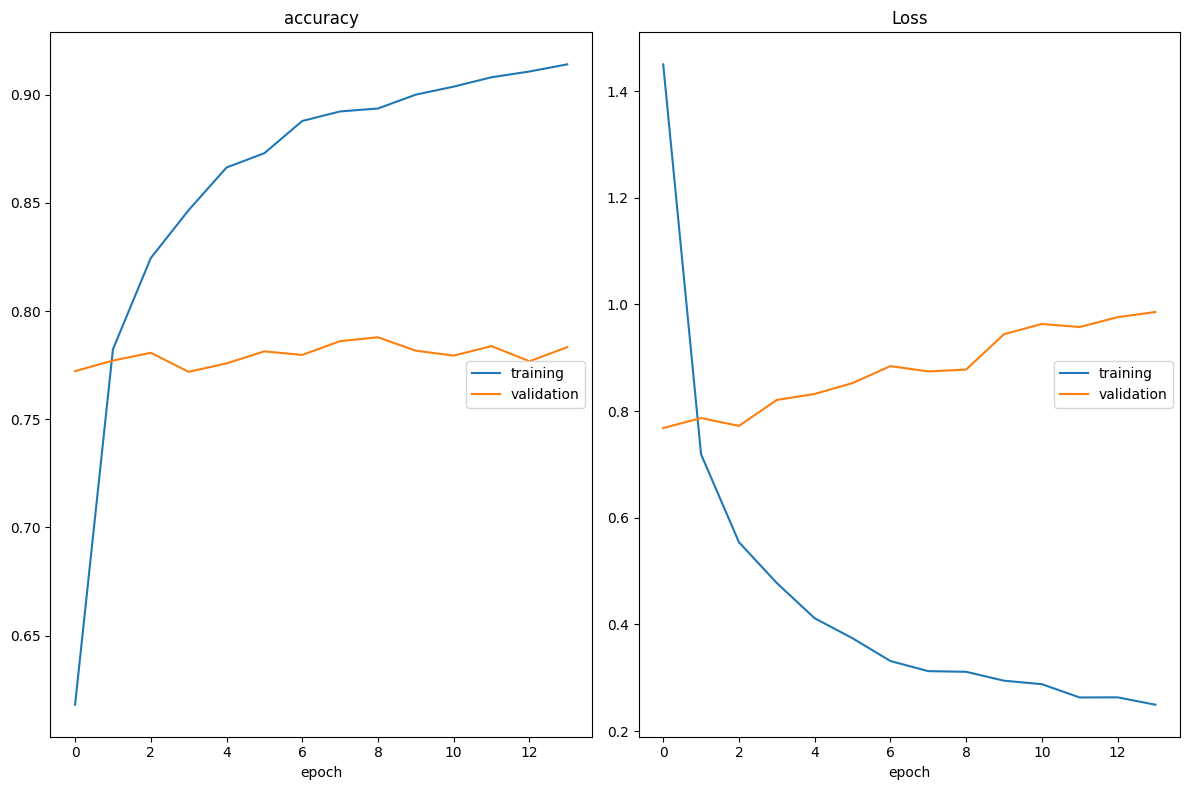

accuracy
	training         	 (min:    0.618, max:    0.914, cur:    0.914)
	validation       	 (min:    0.772, max:    0.788, cur:    0.783)
Loss
	training         	 (min:    0.250, max:    1.450, cur:    0.250)
	validation       	 (min:    0.768, max:    0.986, cur:    0.986)

Epoch 14: val_accuracy did not improve from 0.78793
483/483 [==============================] - 37s 76ms/step - loss: 0.2496 - accuracy: 0.9141 - val_loss: 0.9859 - val_accuracy: 0.7834


In [26]:
epochs = 25  
history = model.fit(train_data, 
                    epochs=epochs, 
                    validation_data=val_data,
                    callbacks=callbacks)

In [27]:
test_loss, test_accuracy = model.evaluate(test_data)
print('Test Loss:', test_loss)
print("Test Accuracy:", test_accuracy)

65/65 [==============================] - 4s 60ms/step - loss: 0.8884 - accuracy: 0.7868
Test Loss: 0.8883551359176636
Test Accuracy: 0.786782443523407


    - Le premier modèle pré-entrainé que nous avons testé présente de meilleurs résultats sur les données de validation que les modèles crées "from scratch". 
    - Cependant la courbe d'accuracy sur les données de validation ne croit pas contrairement à la courbe des données d'entrainement, ce qui peut indiquer que le modèle est en surapprentissage. 
    - Nous allons utiliser les données augmentées et réentrainer le modèle :

### 1.b EfficientNetB0 : data augmentation 

In [28]:
# Créer une fonction pour appliquer les transformations d'images
def augment_data(images, labels):
    # Convertir les images en flottants et mettre à l'échelle entre 0 et 1
    images = tf.image.convert_image_dtype(images, tf.float32)

    # Appliquer les transformations
    images = tf.image.random_flip_left_right(images)
    images = tf.image.random_flip_up_down(images)
    images = tf.image.random_brightness(images, max_delta=0.2)
    images = tf.image.random_contrast(images, lower=0.8, upper=1.2)
    images = tf.image.random_saturation(images, lower=0.8, upper=1.2)
    images = tf.image.random_hue(images, max_delta=0.1)

    return images, labels

# Appliquer les transformations sur les données d'entraînement
train_data_augmented = train_data.map(augment_data)

In [29]:
# Concaténer les données initiales et les données augmentées
combined_train_data = train_data_augmented.concatenate(train_data)

In [32]:
from tensorflow.keras.models import load_model

In [33]:
# Charger le modèle à partir du point de contrôle sauvegardé
saved_model = load_model('Models/EfficientNet.h5')

In [36]:
plotloss = PlotLossesKeras()
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, mode='max'),
model_checkpoint = ModelCheckpoint(filepath='Models/EfficientNet.h5', monitor='val_accuracy',verbose=1, save_best_only=True, mode='max')
callbacks = [plotloss, early_stopping, model_checkpoint]

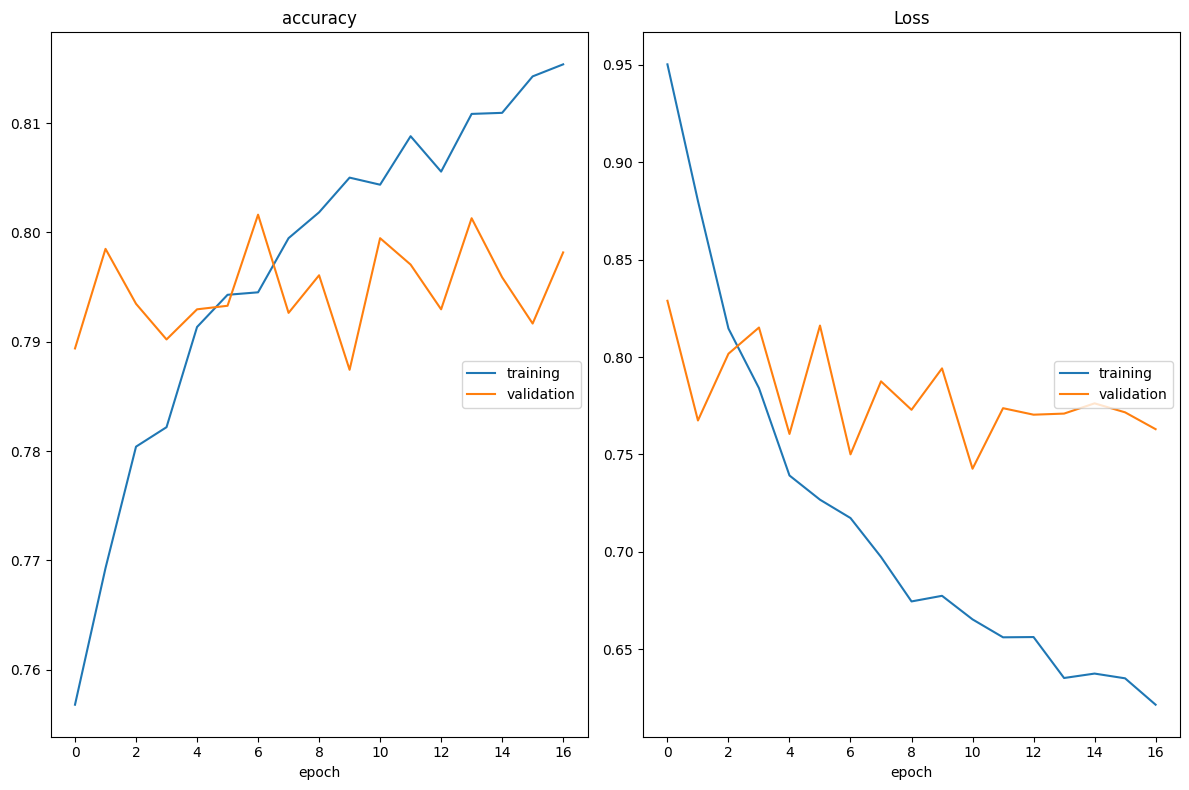

accuracy
	training         	 (min:    0.757, max:    0.815, cur:    0.815)
	validation       	 (min:    0.787, max:    0.802, cur:    0.798)
Loss
	training         	 (min:    0.622, max:    0.950, cur:    0.622)
	validation       	 (min:    0.743, max:    0.829, cur:    0.763)

Epoch 17: val_accuracy did not improve from 0.80163
966/966 [==============================] - 69s 71ms/step - loss: 0.6216 - accuracy: 0.8154 - val_loss: 0.7630 - val_accuracy: 0.7982


In [37]:
epochs=25
history = saved_model.fit(combined_train_data,
                          epochs=epochs,
                          validation_data=val_data,
                          callbacks=callbacks)

In [38]:
test_loss, test_accuracy = saved_model.evaluate(test_data)
print('Test Loss:', test_loss)
print("Test Accuracy:", test_accuracy)

65/65 [==============================] - 4s 60ms/step - loss: 0.7536 - accuracy: 0.8014
Test Loss: 0.7535839080810547
Test Accuracy: 0.8014423251152039


## 2. Modèle Xception

In [5]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

In [6]:
def make_model(base_model, input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    
    base_model.trainable = False
    
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)  # Ajouter une couche de dropout pour la régularisation
    x = Dense(256, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs=base_model.input, outputs=outputs)
    return model

In [60]:
from tensorflow.keras.applications.xception import preprocess_input

In [61]:
# Prétraiter les données d'entraînement
train_data = train_data.map(lambda x, y: (preprocess_input(x), y))

In [62]:
# Prétraiter les données de validation
val_data = val_data.map(lambda x, y: (preprocess_input(x), y))

# Prétraiter les données de test
test_data = test_data.map(lambda x, y: (preprocess_input(x), y))

combined_train_data = combined_train_data.map(lambda x, y: (preprocess_input(x), y))

In [63]:
image_size = (224, 224)
num_classes = 120
input_shape = image_size + (3,)

base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

with tf.device('/GPU:0'):
    model_xception = make_model(base_model=base_model, input_shape=input_shape, num_classes=num_classes)

In [64]:
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model_xception.compile(optimizer=optimizer, 
                       loss="sparse_categorical_crossentropy",
                       metrics=["accuracy"])

In [57]:
# model_xception.compile(loss="sparse_categorical_crossentropy", 
#               optimizer="rmsprop", 
#               metrics=["accuracy"])

In [65]:
plotloss = PlotLossesKeras()
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, mode='max'),
model_checkpoint = ModelCheckpoint(filepath='Models/Xception.h5', monitor='val_accuracy',verbose=1, save_best_only=True, mode='max')
callbacks = [plotloss, early_stopping, model_checkpoint]

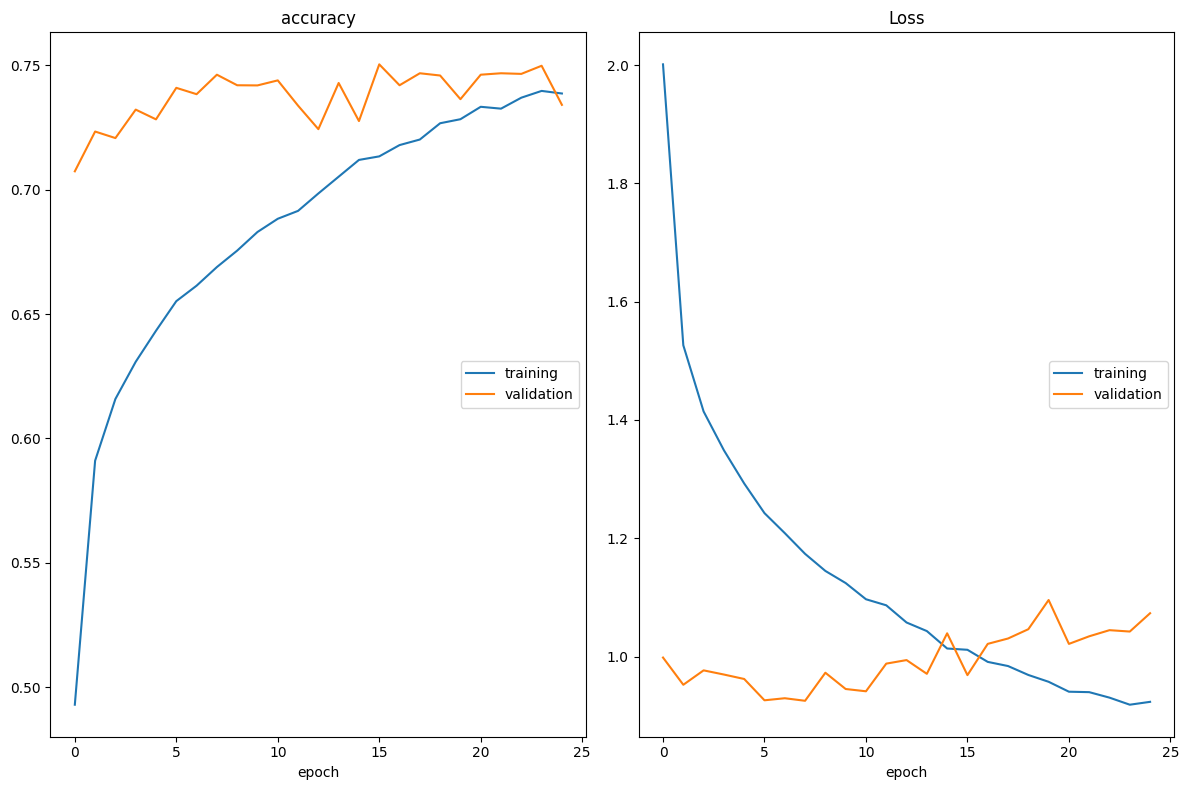

accuracy
	training         	 (min:    0.493, max:    0.740, cur:    0.739)
	validation       	 (min:    0.707, max:    0.750, cur:    0.734)
Loss
	training         	 (min:    0.919, max:    2.001, cur:    0.923)
	validation       	 (min:    0.925, max:    1.096, cur:    1.073)

Epoch 25: val_accuracy did not improve from 0.75033
966/966 [==============================] - 112s 115ms/step - loss: 0.9235 - accuracy: 0.7386 - val_loss: 1.0733 - val_accuracy: 0.7340


In [66]:
epochs = 25  
history = model_xception.fit(combined_train_data, 
                             epochs=epochs, 
                             validation_data=val_data,
                             callbacks=callbacks)

In [67]:
test_loss, test_accuracy = model_xception.evaluate(test_data)
print('Test Loss:', test_loss)
print("Test Accuracy:", test_accuracy)

65/65 [==============================] - 7s 102ms/step - loss: 0.9959 - accuracy: 0.7413
Test Loss: 0.995864748954773
Test Accuracy: 0.7413461804389954


## 3. Modèle InceptionResNetV2 :

In [4]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as incep_process

In [6]:
# Charger les données à partir des répertoires redimensionnés

train_data, val_test = tf.keras.preprocessing.image_dataset_from_directory(
    "Resized_Images",
    labels="inferred",
    label_mode="int",
    image_size=(256, 256),
    batch_size=32,
    shuffle=True,
    seed=0,
    validation_split=0.25,  # la proportion de données à utiliser pour la validation + test
    subset="both",
)

# Mélanger l'ensemble validation + test
val_test_shuffled = val_test.shuffle(buffer_size=len(val_test))

# Définir la taille des ensembles de validation et de test
val_size = int(0.6 * len(val_test_shuffled))

# Séparer les ensembles de validation et de test
val_data = val_test_shuffled.take(val_size)
test_data = val_test_shuffled.skip(val_size)

Found 20580 files belonging to 120 classes.
Using 15435 files for training.
Using 5145 files for validation.


In [81]:
# Créer une fonction pour appliquer les transformations d'images
def augment_data(images, labels):
    # Convertir les images en flottants et mettre à l'échelle entre 0 et 1
    images = tf.image.convert_image_dtype(images, tf.float32)

    # Appliquer les transformations
    images = tf.image.random_flip_left_right(images)
    images = tf.image.random_flip_up_down(images)
    images = tf.image.random_brightness(images, max_delta=0.2)
    images = tf.image.random_contrast(images, lower=0.8, upper=1.2)
    images = tf.image.random_saturation(images, lower=0.8, upper=1.2)
    images = tf.image.random_hue(images, max_delta=0.1)

    return images, labels

# Appliquer les transformations sur les données d'entraînement
train_data_augmented = train_data.map(augment_data)

# Concaténer les données initiales et les données augmentées
combined_train_data = train_data.concatenate(train_data_augmented)


Prétraiter les données pour les adapter au modèle InceptionResNetV2

In [8]:
# Prétraiter les données d'entraînement
train_data_incep = train_data.map(lambda x, y: (incep_process(x), y))

# Prétraiter les données de validation
val_data_incep = val_data.map(lambda x, y: (incep_process(x), y))

# Prétraiter les données de test
test_data_incep = test_data.map(lambda x, y: (incep_process(x), y))

# tétraiter les données augmentées
combined_train_data_incep = combined_train_data.map(lambda x, y: (incep_process(x), y))

In [75]:
image_size = (256, 256)
num_classes = 120
input_shape = image_size + (3,)

base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

with tf.device('/GPU:0'):
    model_inception_rest_netv2 = make_model(base_model=base_model, input_shape=input_shape, num_classes=num_classes)

219055592/219055592 [==============================] - 8s 0us/step


In [85]:
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model_inception_rest_netv2.compile(optimizer=optimizer, 
                                   loss="sparse_categorical_crossentropy",
                                   metrics=["accuracy"])

In [86]:
plotloss = PlotLossesKeras()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min'),
model_checkpoint = ModelCheckpoint(filepath='Models/InceptionResNetV2.h5', monitor='val_loss',verbose=1, save_best_only=True, mode='min')
callbacks = [plotloss, early_stopping, model_checkpoint]

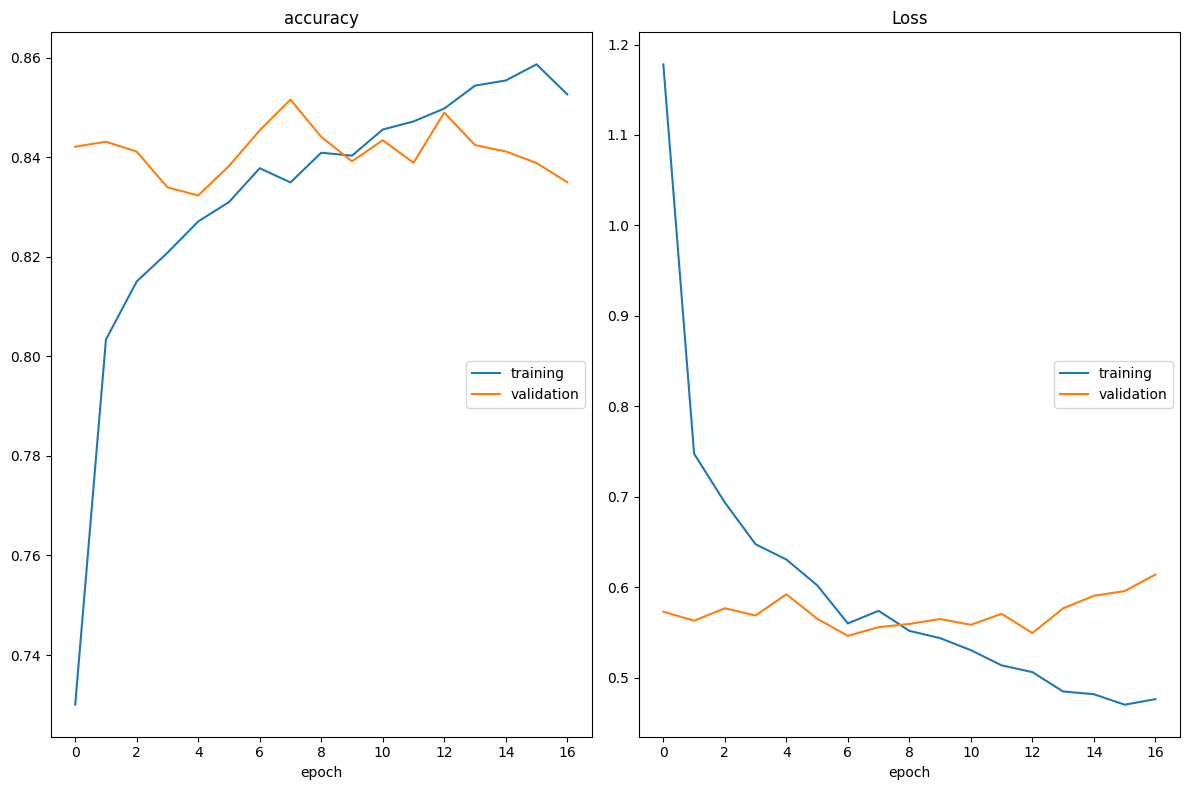

accuracy
	training         	 (min:    0.730, max:    0.859, cur:    0.853)
	validation       	 (min:    0.832, max:    0.852, cur:    0.835)
Loss
	training         	 (min:    0.470, max:    1.178, cur:    0.477)
	validation       	 (min:    0.546, max:    0.614, cur:    0.614)

Epoch 17: val_loss did not improve from 0.54646
483/483 [==============================] - 106s 218ms/step - loss: 0.4765 - accuracy: 0.8526 - val_loss: 0.6143 - val_accuracy: 0.8350


In [87]:
epochs = 25  
history = model_inception_rest_netv2.fit(train_data_incep, 
                                         epochs=epochs, 
                                         validation_data=val_data_incep,
                                         callbacks=callbacks)

In [88]:
test_loss, test_accuracy = model_inception_rest_netv2.evaluate(test_data_incep)
print('Test Loss:', test_loss)
print("Test Accuracy:", test_accuracy)

65/65 [==============================] - 12s 176ms/step - loss: 0.5263 - accuracy: 0.8500
Test Loss: 0.5262561440467834
Test Accuracy: 0.8499758839607239


### 3.b InceptionResNetV2 : 
    - Deuxième essai avec :
        - l'optimizer RMSprop 
        - Décroissance du learning rate avec la fonction ExponentialDecay
    - Troisième essai avec :
        - Ajout de données augmentées

In [9]:
from tensorflow.keras.models import load_model
# Charger le modèle à partir du point de contrôle sauvegardé
saved_InceptionResNetV2 = load_model('Models/InceptionResNetV2.h5')

In [104]:
# Création de la fonction de décroissante du learning rate
learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True)

# Création de l'optimiseur RMSprop avec le learning_rate décroissant
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate_schedule)

saved_InceptionResNetV2.compile(optimizer=optimizer, 
                                   loss="sparse_categorical_crossentropy",
                                   metrics=["accuracy"])

In [105]:
plotloss = PlotLossesKeras()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min'),
model_checkpoint = ModelCheckpoint(filepath='Models/InceptionResNetV2_2.h5', monitor='val_loss',verbose=1, save_best_only=True, mode='min')
callbacks = [plotloss, early_stopping, model_checkpoint]

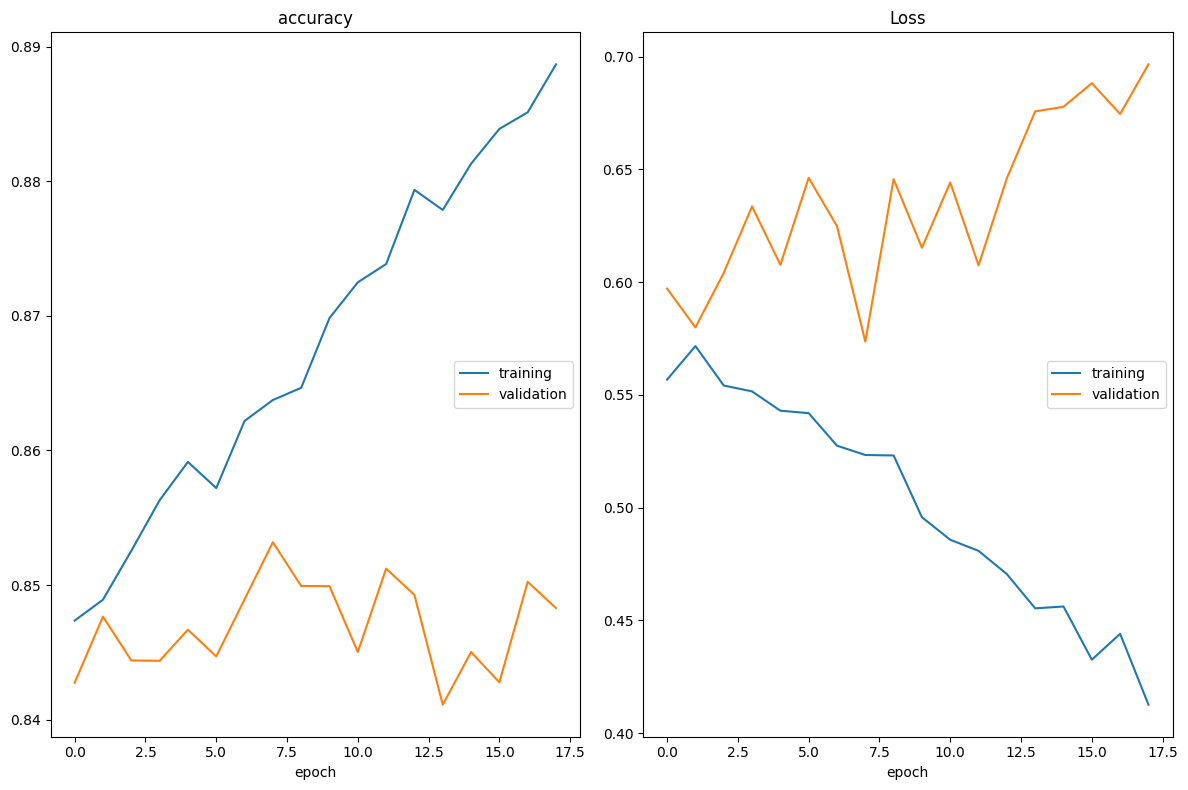

accuracy
	training         	 (min:    0.847, max:    0.889, cur:    0.889)
	validation       	 (min:    0.841, max:    0.853, cur:    0.848)
Loss
	training         	 (min:    0.413, max:    0.572, cur:    0.413)
	validation       	 (min:    0.574, max:    0.697, cur:    0.697)

Epoch 18: val_loss did not improve from 0.57361
483/483 [==============================] - 106s 219ms/step - loss: 0.4126 - accuracy: 0.8887 - val_loss: 0.6966 - val_accuracy: 0.8483


In [106]:
epochs = 25  
history = saved_InceptionResNetV2.fit(train_data_incep, 
                                      epochs=epochs, 
                                      validation_data=val_data_incep,
                                      callbacks=callbacks)

In [107]:
test_loss, test_accuracy = saved_InceptionResNetV2.evaluate(test_data_incep)
print('Test Loss:', test_loss)
print("Test Accuracy:", test_accuracy)

65/65 [==============================] - 12s 177ms/step - loss: 0.6301 - accuracy: 0.8399
Test Loss: 0.6301321387290955
Test Accuracy: 0.8399038314819336


## 3.c InceptionResNetV2 :

In [111]:
from tensorflow.keras.models import load_model
# Charger le modèle à partir du point de contrôle sauvegardé
saved_InceptionResNetV2 = load_model('Models/InceptionResNetV2.h5')

In [10]:
# Création de la fonction de décroissante du learning rate
learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True)

# Création de l'optimiseur RMSprop avec le learning_rate décroissant
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate_schedule)

saved_InceptionResNetV2.compile(optimizer=optimizer, 
                                   loss="sparse_categorical_crossentropy",
                                   metrics=["accuracy"])

In [11]:
plotloss = PlotLossesKeras()
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, mode='min'),
model_checkpoint = ModelCheckpoint(filepath='Models/InceptionResNetV2_3.h5', monitor='val_loss',verbose=1, save_best_only=True, mode='min')
callbacks = [plotloss, early_stopping, model_checkpoint]

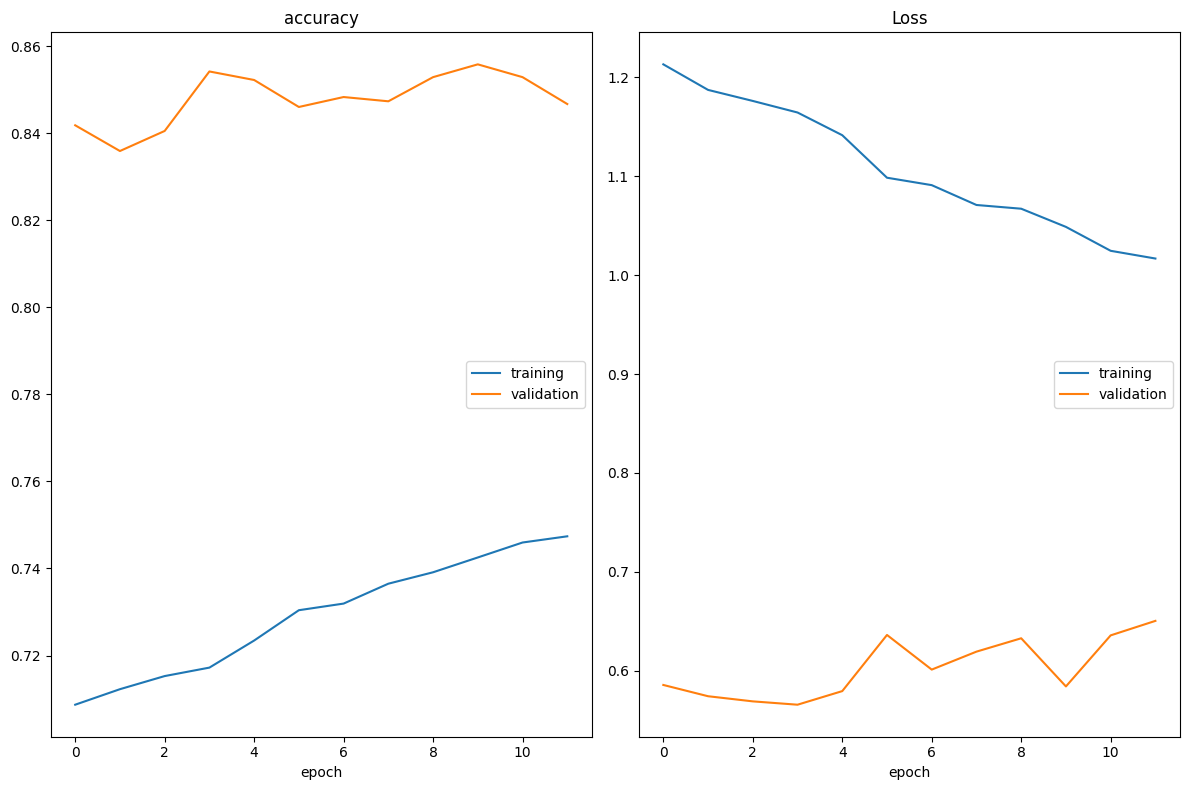

accuracy
	training         	 (min:    0.709, max:    0.747, cur:    0.747)
	validation       	 (min:    0.836, max:    0.856, cur:    0.847)
Loss
	training         	 (min:    1.017, max:    1.213, cur:    1.017)
	validation       	 (min:    0.566, max:    0.650, cur:    0.650)

Epoch 12: val_loss did not improve from 0.56552
966/966 [==============================] - 192s 199ms/step - loss: 1.0168 - accuracy: 0.7474 - val_loss: 0.6503 - val_accuracy: 0.8467


In [12]:
epochs = 25  
history = saved_InceptionResNetV2.fit(combined_train_data_incep, 
                                      epochs=epochs, 
                                      validation_data=val_data_incep,
                                      callbacks=callbacks)

In [13]:
test_loss, test_accuracy = saved_InceptionResNetV2.evaluate(test_data_incep)
print('Test Loss:', test_loss)
print("Test Accuracy:", test_accuracy)

65/65 [==============================] - 12s 177ms/step - loss: 0.5854 - accuracy: 0.8389
Test Loss: 0.5854051113128662
Test Accuracy: 0.838942289352417


## 4. Modèle NASNetLarge :

In [14]:
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.applications.nasnet import preprocess_input as nasnet_process

Prétraiter les données pour les adapter au modèle NASNetLarge.

Pour charger les poids pré-entraînés d'ImageNet dans le modèle NASNetLarge, les images doivent être redimensionnées en (331, 331)

In [15]:
# Charger les données à partir des répertoires redimensionnés

train_data, val_test = tf.keras.preprocessing.image_dataset_from_directory(
    "Resized_Images",
    labels="inferred",
    label_mode="int",
    image_size=(331, 331), # Adapter les dimmension des images au modèle
    batch_size=32,
    shuffle=True,
    seed=0,
    validation_split=0.25,  
    subset="both",
)

# Mélanger l'ensemble validation + test
val_test_shuffled = val_test.shuffle(buffer_size=len(val_test))

# Définir la taille des ensembles de validation et de test
val_size = int(0.6 * len(val_test_shuffled))

# Séparer les ensembles de validation et de test
val_data = val_test_shuffled.take(val_size)
test_data = val_test_shuffled.skip(val_size)

Found 20580 files belonging to 120 classes.
Using 15435 files for training.
Using 5145 files for validation.


In [16]:
# Prétraiter les données d'entraînement
train_data_nasnet = train_data.map(lambda x, y: (nasnet_process(x), y))

# Prétraiter les données de validation
val_data_nasnet = val_data.map(lambda x, y: (nasnet_process(x), y))

# Prétraiter les données de test
test_data_nasnet = test_data.map(lambda x, y: (nasnet_process(x), y))

# prétraiter les données augmentées
combined_train_data_nasnet = combined_train_data.map(lambda x, y: (nasnet_process(x), y))

In [21]:
image_size = (331, 331)
num_classes = 120
input_shape = image_size + (3,)

base_model = NASNetLarge(weights='imagenet', include_top=False, input_shape=input_shape)
with tf.device('/GPU:0'):
    model_nasnet_large = make_model(base_model=base_model, input_shape=input_shape, num_classes=num_classes)

In [22]:
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model_nasnet_large.compile(optimizer=optimizer, 
                           loss="sparse_categorical_crossentropy",
                           metrics=["accuracy"])

In [23]:
plotloss = PlotLossesKeras()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min'),
model_checkpoint = ModelCheckpoint(filepath='Models/NASNetLarge.h5', monitor='val_loss',verbose=1, save_best_only=True, mode='min')
callbacks = [plotloss, early_stopping, model_checkpoint]

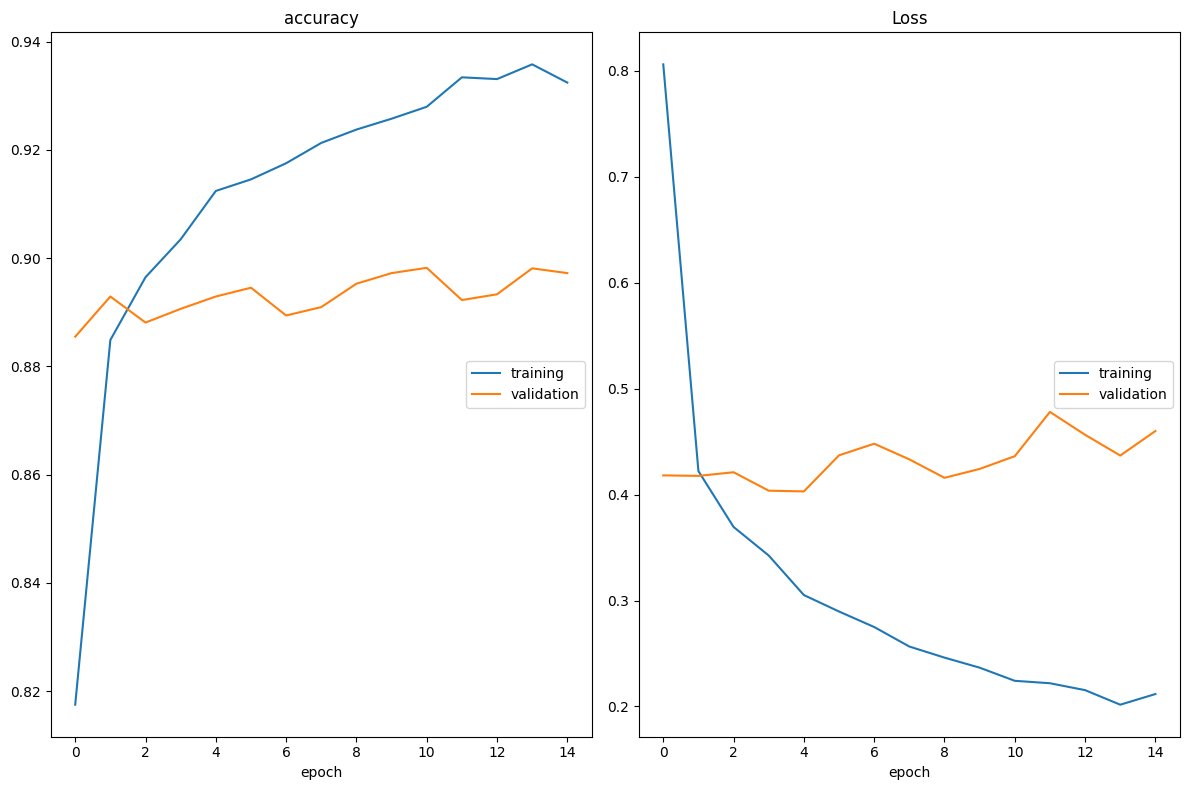

accuracy
	training         	 (min:    0.817, max:    0.936, cur:    0.932)
	validation       	 (min:    0.885, max:    0.898, cur:    0.897)
Loss
	training         	 (min:    0.202, max:    0.806, cur:    0.212)
	validation       	 (min:    0.403, max:    0.478, cur:    0.460)

Epoch 15: val_loss did not improve from 0.40300
483/483 [==============================] - 440s 911ms/step - loss: 0.2117 - accuracy: 0.9324 - val_loss: 0.4600 - val_accuracy: 0.8972


In [24]:
epochs = 25  
history = model_nasnet_large.fit(train_data_nasnet, 
                                 epochs=epochs, 
                                 validation_data=val_data_nasnet,
                                 callbacks=callbacks)

In [25]:
test_loss, test_accuracy = model_nasnet_large.evaluate(test_data_nasnet)
print('Test Loss:', test_loss)
print("Test Accuracy:", test_accuracy)

65/65 [==============================] - 50s 750ms/step - loss: 0.3938 - accuracy: 0.8957
Test Loss: 0.3938402235507965
Test Accuracy: 0.8956730961799622


## 5. Modèle EfficientNetB7 :

In [7]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input as efficient_process

In [9]:
# Charger les données à partir des répertoires redimensionnés

train_data, val_test = tf.keras.preprocessing.image_dataset_from_directory(
    "Resized_Images",
    labels="inferred",
    label_mode="int",
    image_size=(400, 400), # Adapter les dimensions des images au modèle
    batch_size=16,
    shuffle=True,
    seed=0,
    validation_split=0.25,  
    subset="both",
)

# Mélanger l'ensemble validation + test
val_test_shuffled = val_test.shuffle(buffer_size=len(val_test))

# Définir la taille des ensembles de validation et de test
val_size = int(0.6 * len(val_test_shuffled))

# Séparer les ensembles de validation et de test
val_data = val_test_shuffled.take(val_size)
test_data = val_test_shuffled.skip(val_size)

Found 20580 files belonging to 120 classes.
Using 15435 files for training.
Using 5145 files for validation.


In [11]:
# Prétraiter les données d'entraînement
train_data_efficient = train_data.map(lambda x, y: (efficient_process(x), y))

# Prétraiter les données de validation
val_data_efficient = val_data.map(lambda x, y: (efficient_process(x), y))

# Prétraiter les données de test
test_data_efficient = test_data.map(lambda x, y: (efficient_process(x), y))

# tétraiter les données augmentées
# combined_train_data_efficient = combined_train_data.map(lambda x, y: (efficient_process(x), y))

In [12]:
image_size = (400, 400)
num_classes = 120
input_shape = image_size + (3,)

base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)
with tf.device('/GPU:0'):
    model_efficientnet_b7 = make_model(base_model=base_model, input_shape=input_shape, num_classes=num_classes)

In [13]:
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model_efficientnet_b7.compile(optimizer=optimizer, 
                               loss="sparse_categorical_crossentropy",
                               metrics=["accuracy"])

In [14]:
plotloss = PlotLossesKeras()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min'),
model_checkpoint = ModelCheckpoint(filepath='Models/EfficientNetB7.h5', monitor='val_loss',verbose=1, save_best_only=True, mode='min')
callbacks = [plotloss, early_stopping, model_checkpoint]

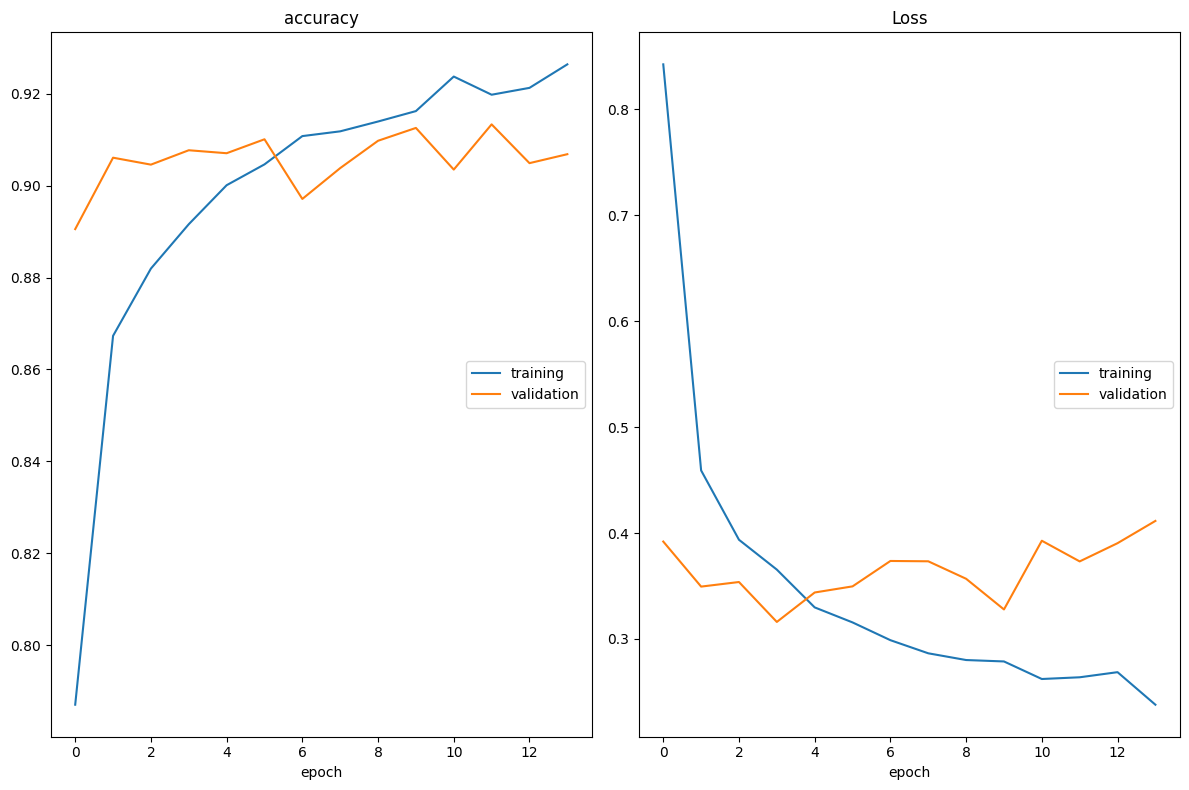

accuracy
	training         	 (min:    0.787, max:    0.926, cur:    0.926)
	validation       	 (min:    0.891, max:    0.913, cur:    0.907)
Loss
	training         	 (min:    0.238, max:    0.843, cur:    0.238)
	validation       	 (min:    0.316, max:    0.411, cur:    0.411)

Epoch 14: val_loss did not improve from 0.31609
965/965 [==============================] - 708s 734ms/step - loss: 0.2379 - accuracy: 0.9264 - val_loss: 0.4115 - val_accuracy: 0.9068


In [15]:
epochs = 25  
history = model_efficientnet_b7.fit(train_data_efficient, 
                                 epochs=epochs, 
                                 validation_data=val_data_efficient,
                                 callbacks=callbacks)

In [16]:
test_loss, test_accuracy = model_efficientnet_b7.evaluate(test_data_efficient)
print('Test Loss:', test_loss)
print("Test Accuracy:", test_accuracy)

129/129 [==============================] - 78s 594ms/step - loss: 0.3303 - accuracy: 0.9026
Test Loss: 0.33028870820999146
Test Accuracy: 0.9026162624359131


## 6. Modèle EfficientNetV2M :

In [17]:
from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as efficientv2_process

In [29]:
# Charger les données à partir des répertoires redimensionnés

train_data, val_test = tf.keras.preprocessing.image_dataset_from_directory(
    "Resized_Images",
    labels="inferred",
    label_mode="int",
    image_size=(300, 300), # Adapter les dimensions des images au modèle
    batch_size=16,
    shuffle=True,
    seed=0,
    validation_split=0.25,  
    subset="both",
)

# Mélanger l'ensemble validation + test
val_test_shuffled = val_test.shuffle(buffer_size=len(val_test))

# Définir la taille des ensembles de validation et de test
val_size = int(0.6 * len(val_test_shuffled))

# Séparer les ensembles de validation et de test
val_data = val_test_shuffled.take(val_size)
test_data = val_test_shuffled.skip(val_size)

Found 20580 files belonging to 120 classes.
Using 15435 files for training.
Using 5145 files for validation.


In [30]:
# Prétraiter les données d'entraînement
train_data_efficient = train_data.map(lambda x, y: (efficientv2_process(x), y))

# Prétraiter les données de validation
val_data_efficient = val_data.map(lambda x, y: (efficientv2_process(x), y))

# Prétraiter les données de test
test_data_efficient = test_data.map(lambda x, y: (efficientv2_process(x), y))

# tétraiter les données augmentées
# combined_train_data_efficient = combined_train_data.map(lambda x, y: (efficientv2_process(x), y))

In [31]:
image_size = (300, 300)
num_classes = 120
input_shape = image_size + (3,)

base_model = EfficientNetV2M(weights='imagenet', include_top=False, input_shape=input_shape)
with tf.device('/GPU:0'):
    model_efficientnet_v2m = make_model(base_model=base_model, input_shape=input_shape, num_classes=num_classes)

In [32]:
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model_efficientnet_v2m.compile(optimizer=optimizer, 
                               loss="sparse_categorical_crossentropy",
                               metrics=["accuracy"])

In [33]:
plotloss = PlotLossesKeras()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min'),
model_checkpoint = ModelCheckpoint(filepath='Models/EfficientNetV2M.h5', monitor='val_loss',verbose=1, save_best_only=True, mode='min')
callbacks = [plotloss, early_stopping, model_checkpoint]

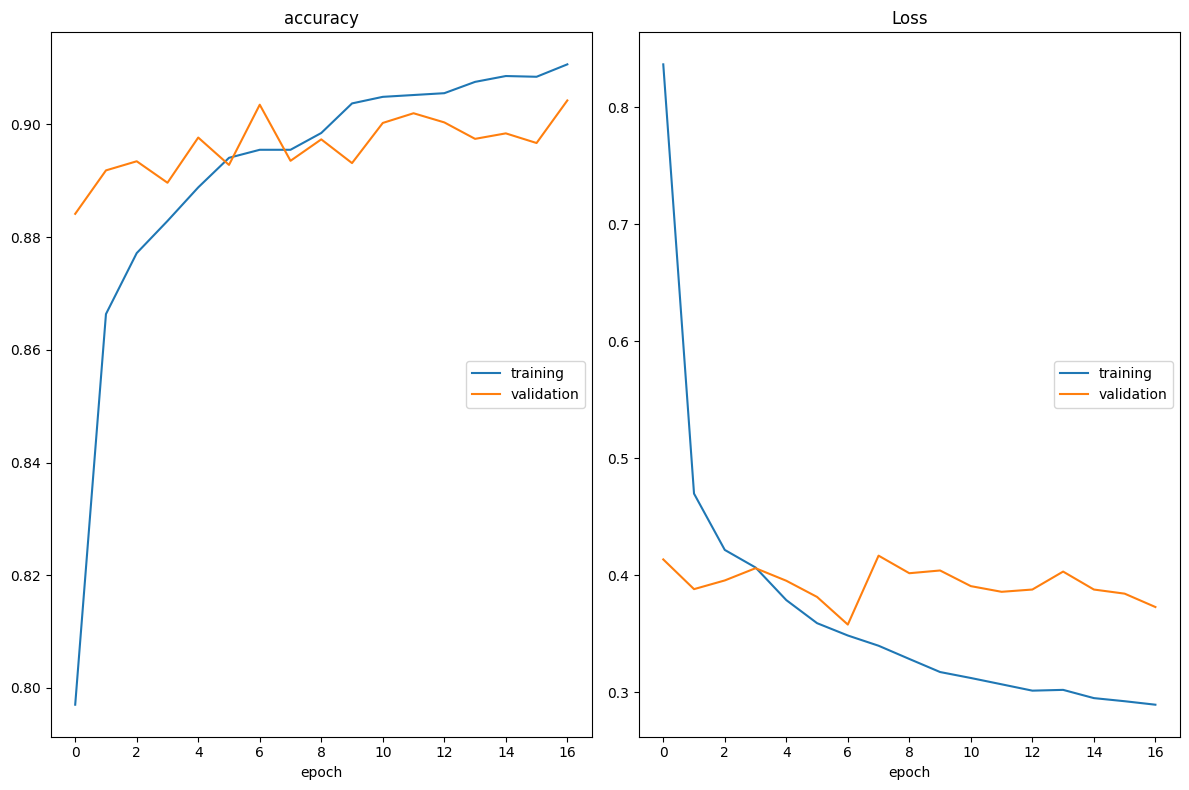

accuracy
	training         	 (min:    0.797, max:    0.911, cur:    0.911)
	validation       	 (min:    0.884, max:    0.904, cur:    0.904)
Loss
	training         	 (min:    0.289, max:    0.837, cur:    0.289)
	validation       	 (min:    0.358, max:    0.417, cur:    0.373)

Epoch 17: val_loss did not improve from 0.35789
965/965 [==============================] - 212s 220ms/step - loss: 0.2894 - accuracy: 0.9107 - val_loss: 0.3729 - val_accuracy: 0.9043


In [34]:
epochs = 25  
history = model_efficientnet_v2m.fit(train_data_efficient, 
                                     epochs=epochs, 
                                     validation_data=val_data_efficient,
                                     callbacks=callbacks)

In [35]:
test_loss, test_accuracy = model_efficientnet_v2m.evaluate(test_data_efficient)
print('Test Loss:', test_loss)
print("Test Accuracy:", test_accuracy)

129/129 [==============================] - 23s 176ms/step - loss: 0.4097 - accuracy: 0.8896
Test Loss: 0.40966513752937317
Test Accuracy: 0.8896450996398926


### 6.b EfficientNetV2M :
    - Chargement des données à partir des données originales - non redimensionnées

In [42]:
# Charger les données à partir des répertoires non redimensionnés

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "data/train",
    labels="inferred",
    label_mode="int",
    image_size=(300, 300), # Adapter les dimensions des images au modèle
    batch_size=16,
    shuffle=True,
    validation_split=None,  
)

Found 15394 files belonging to 120 classes.


In [43]:
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "data/val",
    labels="inferred",
    label_mode="int",
    image_size=(300, 300), # Adapter les dimensions des images au modèle
    batch_size=16,
    shuffle=False,
    validation_split=None,  
)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    "data/test",
    labels="inferred",
    label_mode="int",
    image_size=(300, 300), # Adapter les dimensions des images au modèle
    batch_size=16,
    shuffle=False,
    validation_split=None,  
)

Found 3025 files belonging to 120 classes.
Found 2161 files belonging to 120 classes.


In [44]:
# Prétraiter les données d'entraînement
train_data_efficient = train_data.map(lambda x, y: (efficientv2_process(x), y))

# Prétraiter les données de validation
val_data_efficient = val_data.map(lambda x, y: (efficientv2_process(x), y))

# Prétraiter les données de test
test_data_efficient = test_data.map(lambda x, y: (efficientv2_process(x), y))

In [47]:
image_size = (300, 300)
num_classes = 120
input_shape = image_size + (3,)

base_model = EfficientNetV2M(weights='imagenet', include_top=False, input_shape=input_shape)
with tf.device('/GPU:0'):
    model_efficientnet_v2m = make_model(base_model=base_model, input_shape=input_shape, num_classes=num_classes)

In [48]:
plotloss = PlotLossesKeras()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min'),
model_checkpoint = ModelCheckpoint(filepath='Models/EfficientNetV2M_2.h5', monitor='val_loss',verbose=1, save_best_only=True, mode='min')
callbacks = [plotloss, early_stopping, model_checkpoint]

In [50]:
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model_efficientnet_v2m.compile(optimizer=optimizer, 
                               loss="sparse_categorical_crossentropy",
                               metrics=["accuracy"])

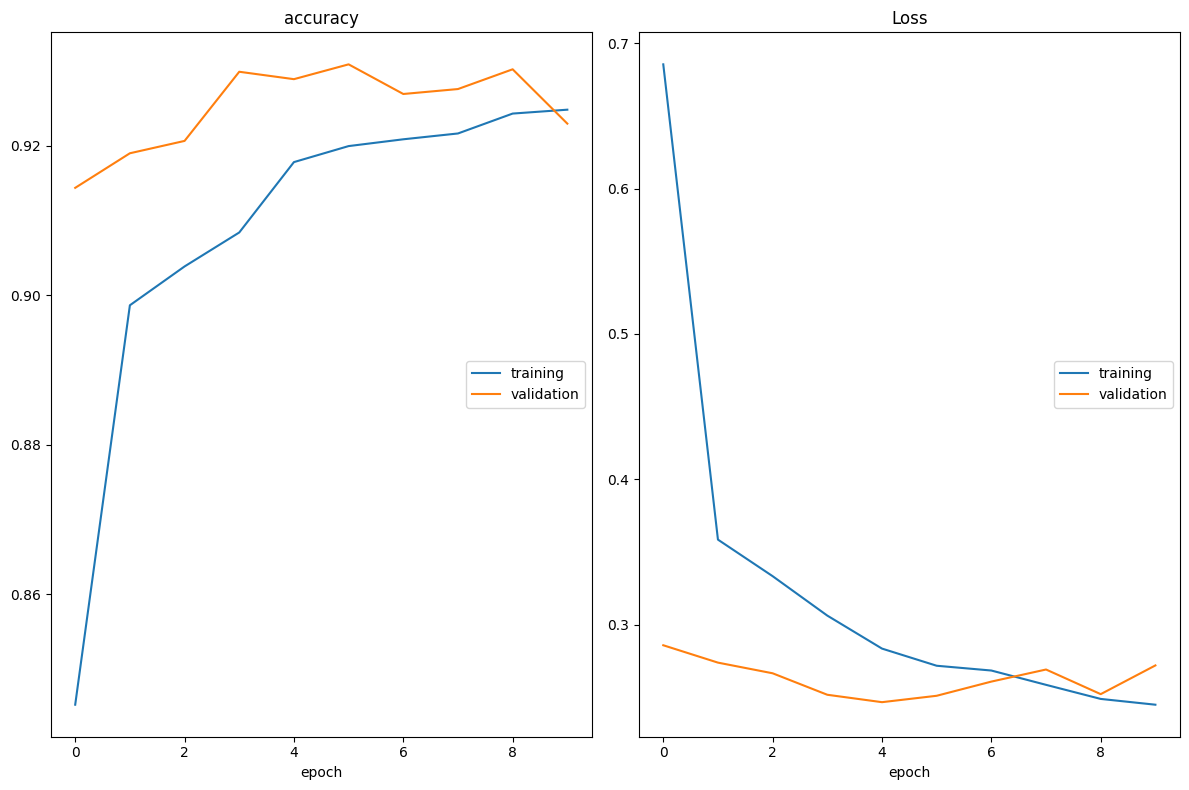

accuracy
	training         	 (min:    0.845, max:    0.925, cur:    0.925)
	validation       	 (min:    0.914, max:    0.931, cur:    0.923)
Loss
	training         	 (min:    0.245, max:    0.686, cur:    0.245)
	validation       	 (min:    0.247, max:    0.286, cur:    0.272)

Epoch 10: val_loss did not improve from 0.24664
963/963 [==============================] - 211s 219ms/step - loss: 0.2449 - accuracy: 0.9248 - val_loss: 0.2719 - val_accuracy: 0.9230


In [51]:
epochs = 25  
history = model_efficientnet_v2m.fit(train_data_efficient, 
                                     epochs=epochs, 
                                     validation_data=val_data_efficient,
                                     callbacks=callbacks)

In [52]:
test_loss, test_accuracy = model_efficientnet_v2m.evaluate(test_data_efficient)
print('Test Loss:', test_loss)
print("Test Accuracy:", test_accuracy)

136/136 [==============================] - 24s 175ms/step - loss: 0.2673 - accuracy: 0.9273
Test Loss: 0.26725539565086365
Test Accuracy: 0.9273484349250793


### 6.c EfficientNetV2M :
    - Réentrainement du modèle 6.b avec l'optimizer RMSprop et ExponentialDecay

In [58]:
from tensorflow.keras.models import load_model
# Charger le dernier modèle sauvegardé
saved_EfficientNetV2M = load_model('Models/EfficientNetV2M_2.h5')

In [59]:
# Création de la fonction de décroissante du learning rate
learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True)

# Création de l'optimiseur RMSprop avec le learning_rate décroissant
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate_schedule)

saved_EfficientNetV2M.compile(optimizer=optimizer, 
                                   loss="sparse_categorical_crossentropy",
                                   metrics=["accuracy"])

In [60]:
plotloss = PlotLossesKeras()
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, mode='min'),
model_checkpoint = ModelCheckpoint(filepath='Models/EfficientNetV2M_4.h5', monitor='val_loss',verbose=1, save_best_only=True, mode='min')
callbacks = [plotloss, early_stopping, model_checkpoint]

In [61]:
import time

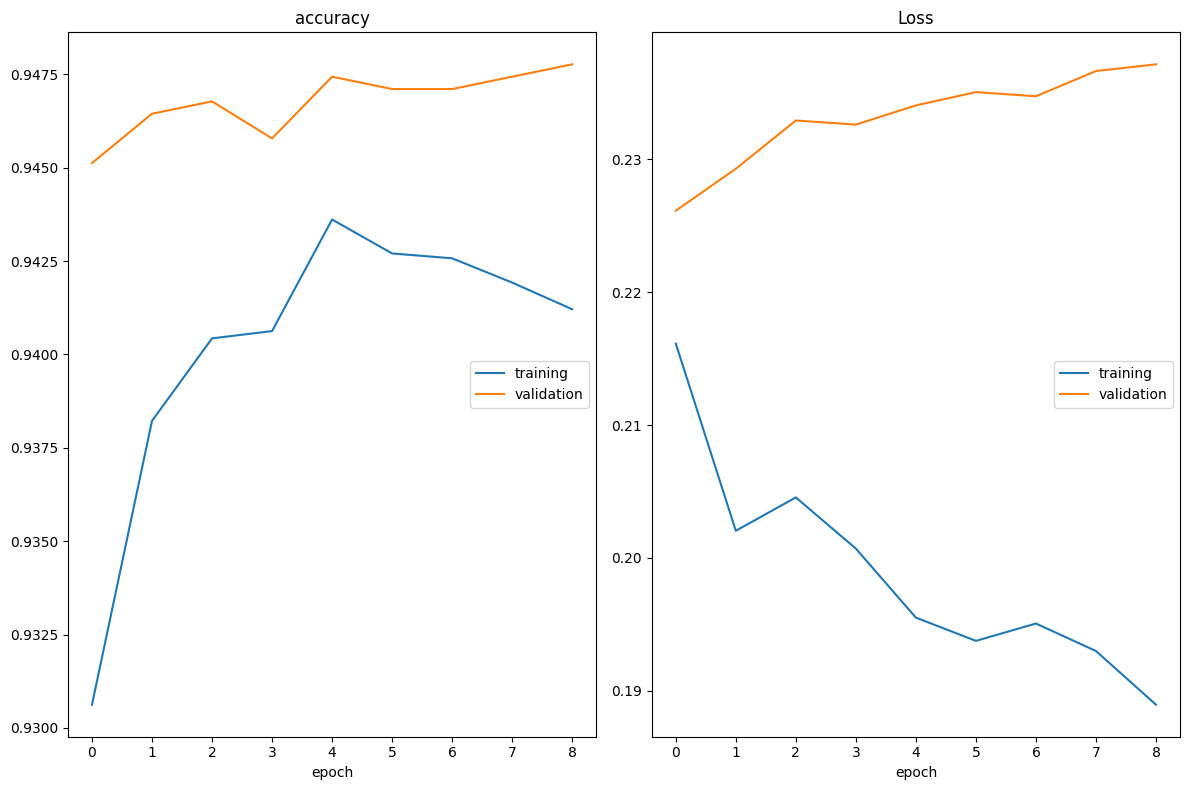

accuracy
	training         	 (min:    0.931, max:    0.944, cur:    0.941)
	validation       	 (min:    0.945, max:    0.948, cur:    0.948)
Loss
	training         	 (min:    0.189, max:    0.216, cur:    0.189)
	validation       	 (min:    0.226, max:    0.237, cur:    0.237)

Epoch 9: val_loss did not improve from 0.22614
963/963 [==============================] - 212s 220ms/step - loss: 0.1889 - accuracy: 0.9412 - val_loss: 0.2372 - val_accuracy: 0.9478
CPU times: user 15min 22s, sys: 4min 21s, total: 19min 43s
Wall time: 32min


In [62]:
%%time
epochs = 25  
history = saved_EfficientNetV2M.fit(train_data_efficient, 
                                      epochs=epochs, 
                                      validation_data=val_data_efficient,
                                      callbacks=callbacks)

In [63]:
test_loss, test_accuracy = saved_EfficientNetV2M.evaluate(test_data_efficient)
print('Test Loss:', test_loss)
print("Test Accuracy:", test_accuracy)

136/136 [==============================] - 24s 178ms/step - loss: 0.2465 - accuracy: 0.9403
Test Loss: 0.24648523330688477
Test Accuracy: 0.9403054118156433


En réduisant le learning rate avec l'optimizer RMSprop, les résultats obtenus avec le modèle EfficientNetV2M sont meilleurs que tous les résultats obtenus jusqu'à présent.

* Autre essai avec le même learning_rate (1e-4) en augmentant le decay_steps : nombres d'étapes avant la décroissance du learning_rate (10000)

In [74]:
from tensorflow.keras.models import load_model
# Charger le dernier modèle sauvegardé
saved_EfficientNetV2M = load_model('Models/EfficientNetV2M_2.h5')

In [75]:
# Création de la fonction de décroissante du learning rate
learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

# Création de l'optimiseur RMSprop avec le learning_rate décroissant
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate_schedule)

saved_EfficientNetV2M.compile(optimizer=optimizer, 
                                   loss="sparse_categorical_crossentropy",
                                   metrics=["accuracy"])

In [76]:
plotloss = PlotLossesKeras()
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, mode='min'),
model_checkpoint = ModelCheckpoint(filepath='Models/EfficientNetV2M_5.h5', monitor='val_loss',verbose=1, save_best_only=True, mode='min')
callbacks = [plotloss, early_stopping, model_checkpoint]

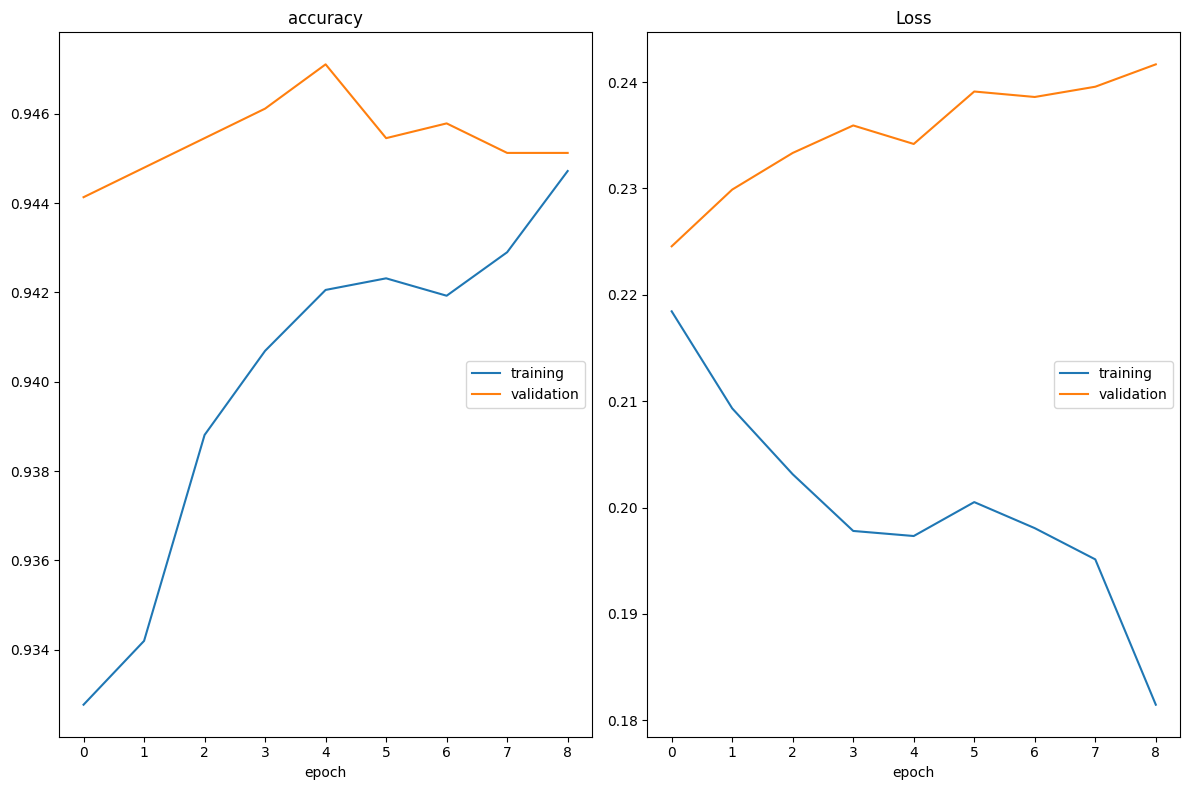

accuracy
	training         	 (min:    0.933, max:    0.945, cur:    0.945)
	validation       	 (min:    0.944, max:    0.947, cur:    0.945)
Loss
	training         	 (min:    0.181, max:    0.218, cur:    0.181)
	validation       	 (min:    0.225, max:    0.242, cur:    0.242)

Epoch 9: val_loss did not improve from 0.22456
963/963 [==============================] - 212s 220ms/step - loss: 0.1815 - accuracy: 0.9447 - val_loss: 0.2417 - val_accuracy: 0.9451
CPU times: user 15min 14s, sys: 4min 18s, total: 19min 32s
Wall time: 32min


In [77]:
%%time
epochs = 25  
history = saved_EfficientNetV2M.fit(train_data_efficient, 
                                      epochs=epochs, 
                                      validation_data=val_data_efficient,
                                      callbacks=callbacks)

In [78]:
test_loss, test_accuracy = saved_EfficientNetV2M.evaluate(test_data_efficient)
print('Test Loss:', test_loss)
print("Test Accuracy:", test_accuracy)

136/136 [==============================] - 24s 177ms/step - loss: 0.2457 - accuracy: 0.9371
Test Loss: 0.24565359950065613
Test Accuracy: 0.9370661973953247


* Les performances sont légèrement inférieures à celle obtenues avec decay_steps=1000

## 6.d EfficientNetV2M : data augmentation

In [5]:
# Charger les données à partir des répertoires non redimensionnés

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "data/train",
    labels="inferred",
    label_mode="int",
    image_size=(300, 300), # Adapter les dimensions des images au modèle
    batch_size=16,
    shuffle=True,
    validation_split=None,  
)

Found 15394 files belonging to 120 classes.


2024-03-12 22:42:24.312479: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 22:42:24.312594: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 22:42:24.312663: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [86]:
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "data/val",
    labels="inferred",
    label_mode="int",
    image_size=(300, 300), # Adapter les dimensions des images au modèle
    batch_size=16,
    shuffle=False,
    validation_split=None,  
)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    "data/test",
    labels="inferred",
    label_mode="int",
    image_size=(300, 300), # Adapter les dimensions des images au modèle
    batch_size=16,
    shuffle=False,
    validation_split=None,  
)

Found 3025 files belonging to 120 classes.
Found 2161 files belonging to 120 classes.


In [87]:
# Créer une fonction pour appliquer les transformations d'images
def augment_data(images, labels):
    # Convertir les images en flottants et mettre à l'échelle entre 0 et 1
    images = tf.image.convert_image_dtype(images, tf.float32)

    # Appliquer les transformations
    images = tf.image.random_flip_left_right(images)
    images = tf.image.random_flip_up_down(images)
    images = tf.image.random_brightness(images, max_delta=0.2)
    images = tf.image.random_contrast(images, lower=0.8, upper=1.2)
    images = tf.image.random_saturation(images, lower=0.8, upper=1.2)
    images = tf.image.random_hue(images, max_delta=0.1)

    return images, labels

# Appliquer les transformations sur les données d'entraînement
train_data_augmented = train_data.map(augment_data)

# Concaténer les données initiales et les données augmentées
combined_train_data = train_data.concatenate(train_data_augmented)

In [88]:
# Prétraiter les données d'entraînement
# train_data_efficient = train_data.map(lambda x, y: (efficientv2_process(x), y))
combined_data_efficient = combined_train_data.map(lambda x, y: (efficientv2_process(x), y))

# Prétraiter les données de validation
val_data_efficient = val_data.map(lambda x, y: (efficientv2_process(x), y))

# Prétraiter les données de test
test_data_efficient = test_data.map(lambda x, y: (efficientv2_process(x), y))

In [89]:
# Charger le dernier modèle sauvegardé
EfficientNetV2M_augmented = load_model('Models/EfficientNetV2M_5.h5')

In [90]:
# Création de la fonction de décroissante du learning rate
learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True)

# Création de l'optimiseur RMSprop avec le learning_rate décroissant
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate_schedule)

saved_EfficientNetV2M.compile(optimizer=optimizer, 
                                   loss="sparse_categorical_crossentropy",
                                   metrics=["accuracy"])

In [91]:
plotloss = PlotLossesKeras()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min'),
model_checkpoint = ModelCheckpoint(filepath='Models/EfficientNetV2M_augmented.h5', monitor='val_loss',verbose=1, save_best_only=True, mode='min')
callbacks = [plotloss, early_stopping, model_checkpoint]

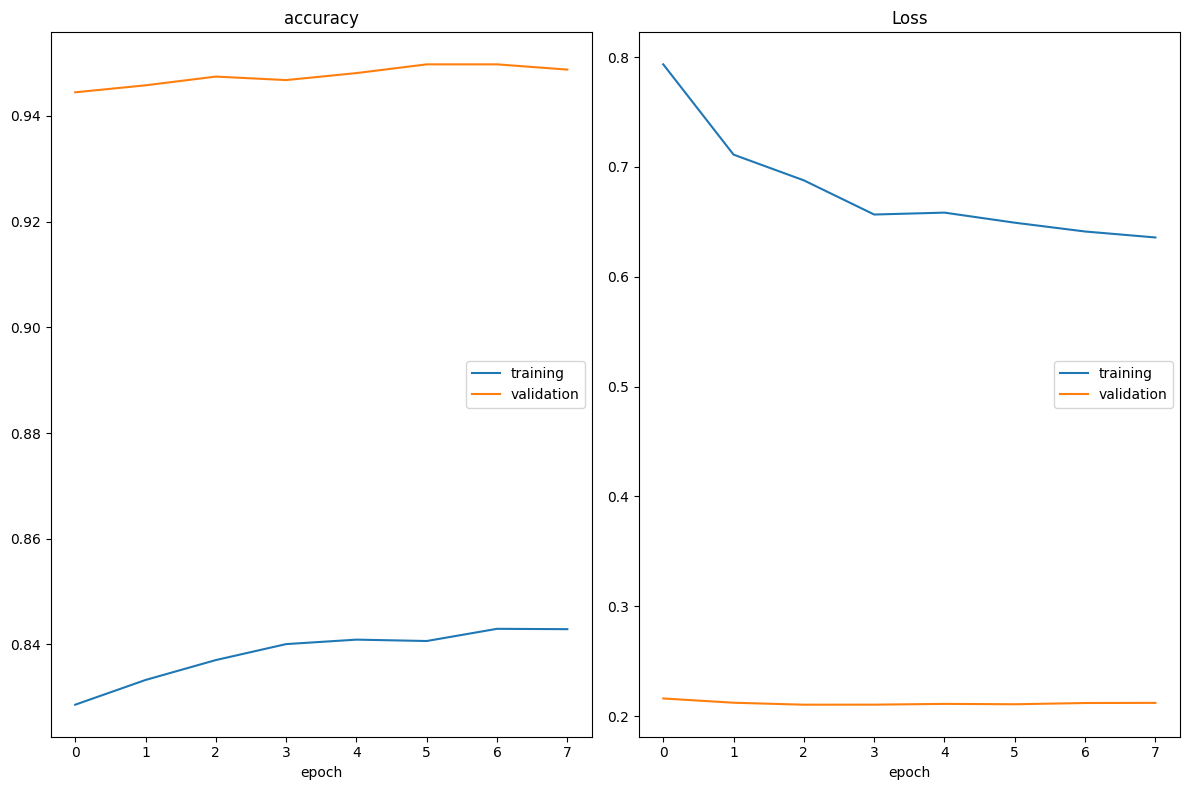

accuracy
	training         	 (min:    0.829, max:    0.843, cur:    0.843)
	validation       	 (min:    0.944, max:    0.950, cur:    0.949)
Loss
	training         	 (min:    0.636, max:    0.793, cur:    0.636)
	validation       	 (min:    0.210, max:    0.216, cur:    0.212)

Epoch 8: val_loss did not improve from 0.21029
1926/1926 [==============================] - 394s 204ms/step - loss: 0.6357 - accuracy: 0.8429 - val_loss: 0.2120 - val_accuracy: 0.9488
CPU times: user 32min 46s, sys: 7min 9s, total: 39min 55s
Wall time: 52min 34s


In [92]:
%%time
epochs = 25  
history = saved_EfficientNetV2M.fit(combined_data_efficient, 
                                      epochs=epochs, 
                                      validation_data=val_data_efficient,
                                      callbacks=callbacks)

In [93]:
test_loss, test_accuracy = saved_EfficientNetV2M.evaluate(test_data_efficient)
print('Test Loss:', test_loss)
print("Test Accuracy:", test_accuracy)

136/136 [==============================] - 24s 178ms/step - loss: 0.2326 - accuracy: 0.9375
Test Loss: 0.232585147023201
Test Accuracy: 0.9375289082527161


In [127]:
EfficientNetV2M_lrDecay = load_model('Models/EfficientNetV2M_2.h5')

In [128]:
# Création de la fonction de décroissante du learning rate
learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.95,
    staircase=True)

# Création de l'optimiseur RMSprop avec le learning_rate décroissant
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate_schedule)

EfficientNetV2M_lrDecay.compile(optimizer=optimizer, 
                                   loss="sparse_categorical_crossentropy",
                                   metrics=["accuracy"])

In [129]:
plotloss = PlotLossesKeras()
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, mode='max', verbose=1),
model_checkpoint = ModelCheckpoint(filepath='Models/EfficientNetV2M_2_lrDecay.h5', monitor='val_accuracy',verbose=1, save_best_only=True, mode='max')
callbacks = [plotloss, early_stopping, model_checkpoint]

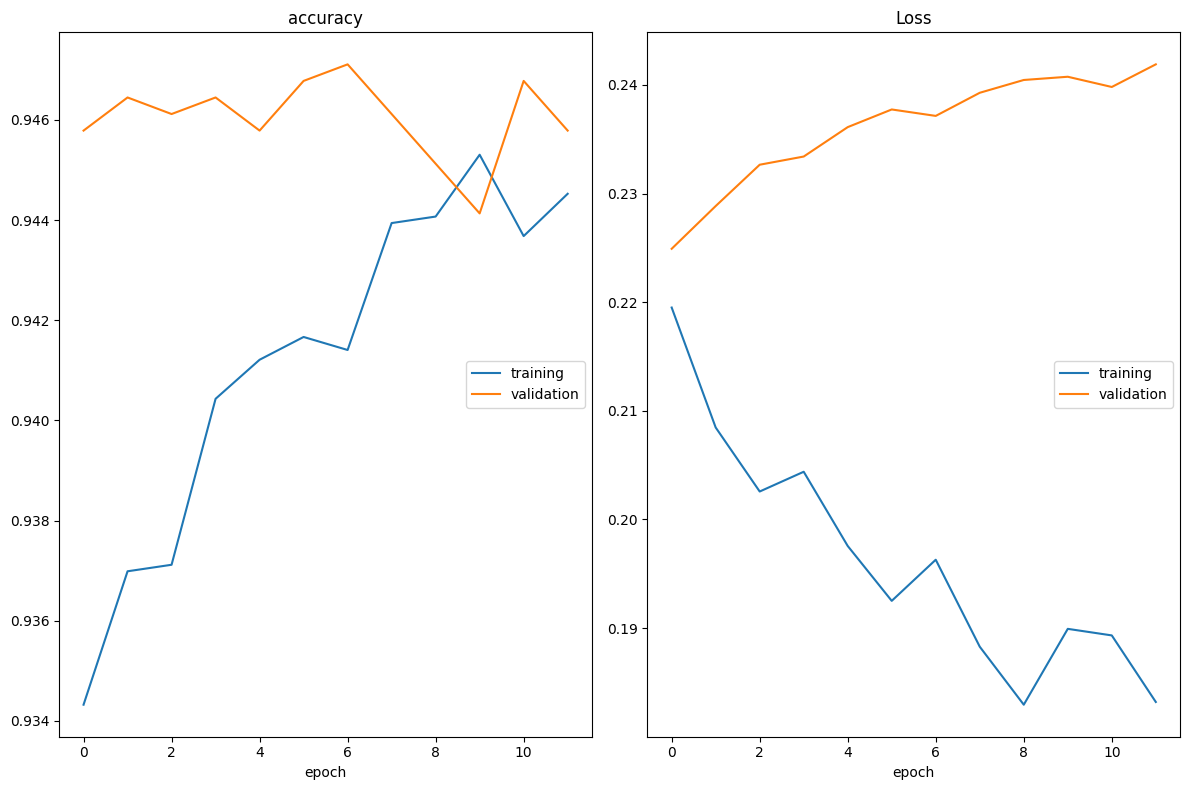

accuracy
	training         	 (min:    0.934, max:    0.945, cur:    0.945)
	validation       	 (min:    0.944, max:    0.947, cur:    0.946)
Loss
	training         	 (min:    0.183, max:    0.220, cur:    0.183)
	validation       	 (min:    0.225, max:    0.242, cur:    0.242)
Restoring model weights from the end of the best epoch: 7.

Epoch 12: val_accuracy did not improve from 0.94711
963/963 [==============================] - 212s 221ms/step - loss: 0.1832 - accuracy: 0.9445 - val_loss: 0.2419 - val_accuracy: 0.9458
Epoch 12: early stopping
CPU times: user 21min 5s, sys: 5min 46s, total: 26min 52s
Wall time: 42min 44s


In [130]:
%%time
epochs = 25  
with tf.device('/gpu:0'): 
    history = EfficientNetV2M_lrDecay.fit(train_data_efficient, 
                                          epochs=epochs, 
                                          verbose=1,
                                          validation_data=val_data_efficient,
                                          callbacks=callbacks)

In [131]:
test_loss, test_accuracy = EfficientNetV2M_lrDecay.evaluate(test_data_efficient)
print('Test Loss:', test_loss)
print("Test Accuracy:", test_accuracy)

136/136 [==============================] - 24s 176ms/step - loss: 0.2572 - accuracy: 0.9412
Test Loss: 0.25722095370292664
Test Accuracy: 0.9412308931350708


In [133]:
from sklearn.metrics import confusion_matrix

In [139]:
# Faire les prédictions sur l'ensemble de données de validation ou de test
predictions = EfficientNetV2M_lrDecay.predict(test_data_efficient)

136/136 [==============================] - 26s 177ms/step


In [135]:
# Convertir les prédictions en classes prédites
predicted_classes = np.argmax(predictions, axis=1)

In [141]:
# Obtenir les étiquettes de classe réelles
true_classes = []
for images, labels in test_data_efficient:
    true_classes.extend(labels.numpy())

# # Obtenir les noms de classe réels
# class_names = list(test_data.class_names)

In [145]:
# # Obtenir les noms de classe réels
class_names = list(test_data.class_names)

In [144]:
# Calculer la matrice de confusion
confusion = confusion_matrix(true_classes, predicted_classes)

# Afficher la matrice de confusion
print("Matrice de confusion :")
print(confusion)


Matrice de confusion :
[[16  0  0 ...  0  0  0]
 [ 0 18  0 ...  0  0  0]
 [ 0  0 25 ...  0  0  0]
 ...
 [ 0  0  0 ... 16  0  0]
 [ 0  0  0 ...  1 14  0]
 [ 0  0  0 ...  0  0 18]]


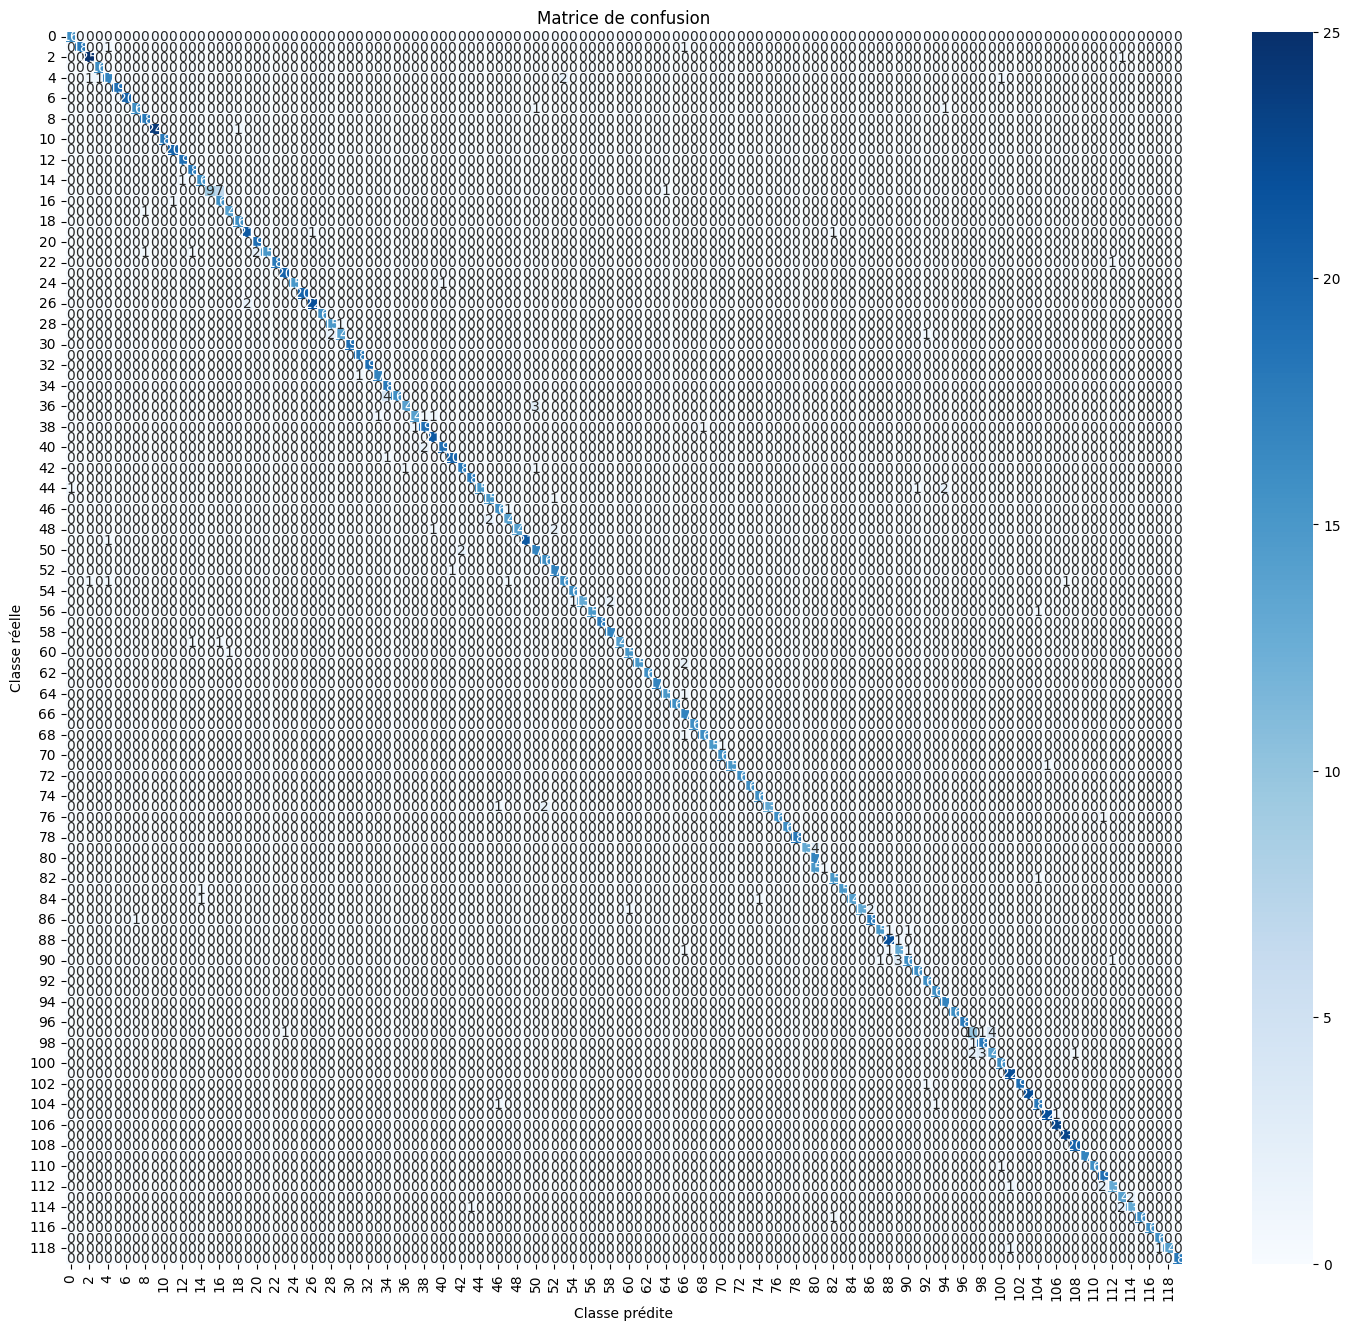

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns

# Définir les classes comme les étiquettes d'axe
plt.figure(figsize=(18, 16))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues") # xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.title('Matrice de confusion')
plt.show()

In [154]:
for i,class_name in enumerate(class_names):
    print(f"Classe n°: {i} : {class_name}")

Classe n°: 0 : n02085620-Chihuahua
Classe n°: 1 : n02085782-Japanese_spaniel
Classe n°: 2 : n02085936-Maltese_dog
Classe n°: 3 : n02086079-Pekinese
Classe n°: 4 : n02086240-Shih-Tzu
Classe n°: 5 : n02086646-Blenheim_spaniel
Classe n°: 6 : n02086910-papillon
Classe n°: 7 : n02087046-toy_terrier
Classe n°: 8 : n02087394-Rhodesian_ridgeback
Classe n°: 9 : n02088094-Afghan_hound
Classe n°: 10 : n02088238-basset
Classe n°: 11 : n02088364-beagle
Classe n°: 12 : n02088466-bloodhound
Classe n°: 13 : n02088632-bluetick
Classe n°: 14 : n02089078-black-and-tan_coonhound
Classe n°: 15 : n02089867-Walker_hound
Classe n°: 16 : n02089973-English_foxhound
Classe n°: 17 : n02090379-redbone
Classe n°: 18 : n02090622-borzoi
Classe n°: 19 : n02090721-Irish_wolfhound
Classe n°: 20 : n02091032-Italian_greyhound
Classe n°: 21 : n02091134-whippet
Classe n°: 22 : n02091244-Ibizan_hound
Classe n°: 23 : n02091467-Norwegian_elkhound
Classe n°: 24 : n02091635-otterhound
Classe n°: 25 : n02091831-Saluki
Classe n°: 

On constate que les images mal étiquetées, notamment la classe "Walker_hound" prédites comme "English_foxhound" correspondent à des races de chien très similaires. 

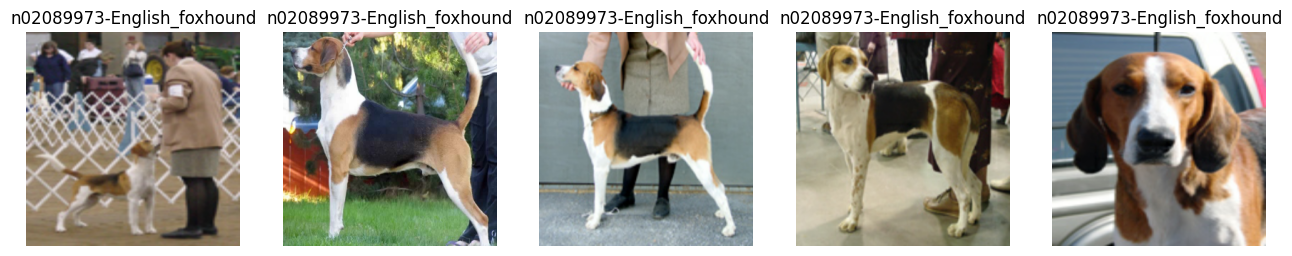

In [163]:
# Classes à afficher
classes_to_display = ["n02089973-English_foxhound"]

# Index des classes dans les données de test
class_indices_to_display = [class_names.index(cls) for cls in classes_to_display]

# Récupérer les images correspondantes et leurs étiquettes
images_to_display = []
labels_to_display = []

for image, label in test_data_efficient.unbatch():
    if label.numpy() in class_indices_to_display:
        images_to_display.append(image.numpy())
        labels_to_display.append(label.numpy())

# Afficher les images
fig, axes = plt.subplots(1, 5, figsize=(16, 6))

for ax, image, label in zip(axes, images_to_display, labels_to_display):
    ax.imshow(image.astype("uint8"))
    ax.set_title(class_names[label])
    ax.axis("off")

plt.show()

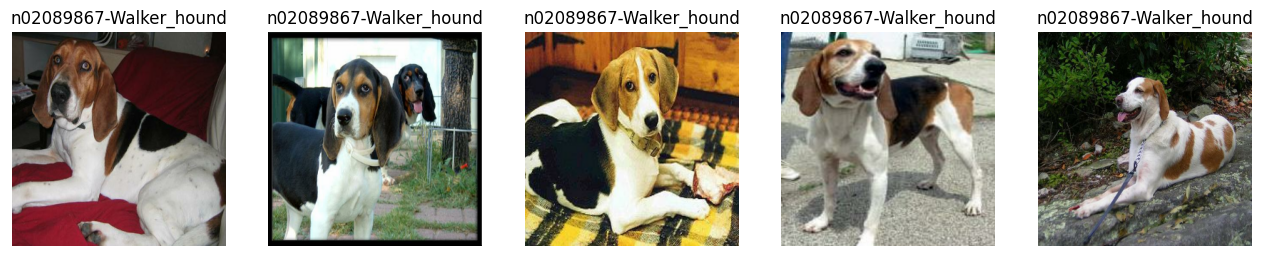

In [162]:
# Classes à afficher
classes_to_display = ["n02089867-Walker_hound"]

# Index des classes dans les données de test
class_indices_to_display = [class_names.index(cls) for cls in classes_to_display]

# Récupérer les images correspondantes et leurs étiquettes
images_to_display = []
labels_to_display = []

for image, label in test_data_efficient.unbatch():
    if label.numpy() in class_indices_to_display:
        images_to_display.append(image.numpy())
        labels_to_display.append(label.numpy())

# Afficher les images
fig, axes = plt.subplots(1, 5, figsize=(16, 6))

for ax, image, label in zip(axes, images_to_display, labels_to_display):
    ax.imshow(image.astype("uint8"))
    ax.set_title(class_names[label])
    ax.axis("off")

plt.show()

In [6]:
import pickle
import re

In [9]:
class_names = train_data.class_names

In [10]:
# Extraire les noms de classe sans les chiffres à l'aide de regex
class_nams_clean = [re.sub(r'^n\d+-', '', class_name) for class_name in class_names]
class_nams_clean

['Chihuahua',
 'Japanese_spaniel',
 'Maltese_dog',
 'Pekinese',
 'Shih-Tzu',
 'Blenheim_spaniel',
 'papillon',
 'toy_terrier',
 'Rhodesian_ridgeback',
 'Afghan_hound',
 'basset',
 'beagle',
 'bloodhound',
 'bluetick',
 'black-and-tan_coonhound',
 'Walker_hound',
 'English_foxhound',
 'redbone',
 'borzoi',
 'Irish_wolfhound',
 'Italian_greyhound',
 'whippet',
 'Ibizan_hound',
 'Norwegian_elkhound',
 'otterhound',
 'Saluki',
 'Scottish_deerhound',
 'Weimaraner',
 'Staffordshire_bullterrier',
 'American_Staffordshire_terrier',
 'Bedlington_terrier',
 'Border_terrier',
 'Kerry_blue_terrier',
 'Irish_terrier',
 'Norfolk_terrier',
 'Norwich_terrier',
 'Yorkshire_terrier',
 'wire-haired_fox_terrier',
 'Lakeland_terrier',
 'Sealyham_terrier',
 'Airedale',
 'cairn',
 'Australian_terrier',
 'Dandie_Dinmont',
 'Boston_bull',
 'miniature_schnauzer',
 'giant_schnauzer',
 'standard_schnauzer',
 'Scotch_terrier',
 'Tibetan_terrier',
 'silky_terrier',
 'soft-coated_wheaten_terrier',
 'West_Highland_wh

In [12]:
# Définir le chemin du fichier pour sauvegarder les noms de classe
file_path = "Models/class_names.pkl"

# Sauvegarder les noms de classe dans le fichier
with open(file_path, "wb") as f:
    pickle.dump(class_nams_clean, f)